# ESM Temperature Profile
The purpose of this notebook is to plot the temperature profiles for the ESM3 temperature data from historic simulations.

The [plotted data](#Plotted-Data) can be found in the bottom half of the document.

#### Dask Import

In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:33633")
client

Client Scheduler: tcp://127.0.0.1:33633 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 6 Cores: 6 Memory: 38.65 GB


<br>

#### Choices for data

In [2]:
#Experiment data for analysis
dataVariableId = 'thetao'
dataExperimentId = 'historical'
dataSourceID = 'E3SM-1-0'

#Ocean Area data for averaging
areaActivityId = 'CMIP'
areaVariableId = 'volcello'
areaSourceId = 'E3SM-1-0'
areaDataSetNo = 0 #First database in results to be used

#Custom Variables
latSel = slice(-89.5,-29.5) #Selected latitude to be investigated
levSel = 5.0
maskName = "OceanMaskVolcello2"

<br>

#### Imports

In [3]:
import cartopy.crs as ccrs
import dask.dataframe as dd
import fsspec
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import zarr

from dask import delayed
from matplotlib.pyplot import cm
from math import isnan
print("Imports complete")

Imports complete


<br>

#### Accessing Dataset Database

In [4]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
print("Database accessed")

Database accessed


<br>

#### Filtering for relevant data sets
ESM3 data sets

In [5]:
dfFilt = df[df.variable_id.eq(dataVariableId) & df.experiment_id.eq(dataExperimentId) & df.source_id.eq(dataSourceID)]
print(str(len(dfFilt))+" datasets found.")
dfFilt

5 datasets found.


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
270973,CMIP,E3SM-Project,E3SM-1-0,historical,r1i1p1f1,Omon,thetao,gr,gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/hi...,NaN,20190826
271590,CMIP,E3SM-Project,E3SM-1-0,historical,r2i1p1f1,Omon,thetao,gr,gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/hi...,NaN,20190830
401412,CMIP,E3SM-Project,E3SM-1-0,historical,r4i1p1f1,Omon,thetao,gr,gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/hi...,NaN,20200129
401422,CMIP,E3SM-Project,E3SM-1-0,historical,r3i1p1f1,Omon,thetao,gr,gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/hi...,NaN,20200129
430635,CMIP,E3SM-Project,E3SM-1-0,historical,r5i1p1f1,Omon,thetao,gr,gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/hi...,NaN,20200429


<br>
Ocean area data to be used for averaging

In [6]:
dfArea = df[df.activity_id.eq(areaActivityId) & df.variable_id.eq(areaVariableId) & df.source_id.eq(areaSourceId)]
print(str(len(dfArea))+" datasets found.")
dfArea.head()

4 datasets found.


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
502770,CMIP,E3SM-Project,E3SM-1-0,historical,r1i1p1f1,Omon,volcello,gr,gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/hi...,NaN,20210127
502774,CMIP,E3SM-Project,E3SM-1-0,piControl,r1i1p1f1,Omon,volcello,gr,gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/pi...,NaN,20210127
502778,CMIP,E3SM-Project,E3SM-1-0,historical,r5i1p1f1,Omon,volcello,gr,gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/hi...,NaN,20210128
502780,CMIP,E3SM-Project,E3SM-1-0,historical,r4i1p1f1,Omon,volcello,gr,gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/hi...,NaN,20210128


<br>

#### Opening all datafiles
ESM3 data

In [7]:
fileSetList = []
for i in range(len(dfFilt)):
    zstore = dfFilt.zstore.values[i]
    mapper = fsspec.get_mapper(zstore)
    fileRaw = xr.open_zarr(mapper, consolidated=True)
    fileSetList.append(fileRaw)
fileCount = len(fileSetList)
if fileCount:
    print(str(fileCount)+" ESM3 data sets opened and stored in fileSetList.")
else:
    print("No ESM3 data sets opened.")

5 ESM3 data sets opened and stored in fileSetList.


Ocean Area data

In [8]:
dsArea = xr.open_zarr(fsspec.get_mapper(dfArea.zstore.values[areaDataSetNo]), consolidated=True)
print("Ocean Area data loaded into dsArea.")

Ocean Area data loaded into dsArea.


Mask data

In [9]:
maskFile = xr.open_dataset(maskName)
oceanMask = maskFile.to_array()
print("Mask data loaded into oceanMask.")

Mask data loaded into oceanMask.


<br>

#### Combine data sets into one xarray

In [10]:
for i in range(fileCount): #Formatting dates into np.datetime64 format
    startDateIterate = np.datetime64(fileSetList[i]['time'].values[0],'M')
    endDateIterate = np.datetime64(fileSetList[i]['time'].values[-1],'M') + np.timedelta64(1,'M')
    fileSetList[i]['time']=('time', np.arange(startDateIterate, endDateIterate, dtype='datetime64[M]'))
    fileSetList[i]['time_bnds']=('time_bnds', np.arange(startDateIterate, endDateIterate, dtype='datetime64[M]')) 
fileSet = xr.combine_nested(fileSetList, concat_dim='RunID') #Combining data sets
print("Data sets successfully merged into fileSet.")
#fileSet #Uncomment to see full data set

Data sets successfully merged into fileSet.


<br>

#### Selection of Data

In [11]:
dataFiltLat = fileSet.thetao.sel(lat=latSel) #Selection of latitude
#dataFiltLatLev = fileSet.thetao.sel(lev=levSel) #Selection of depth
dataFiltFull = dataFiltLat.reset_coords(drop=True) #Removes lev if single value

dataAreaFilt = dsArea.volcello.sel(lat=latSel)
dataAreaFilt = dataAreaFilt.reset_coords(drop=True)

print("Finished data selection, temperature data stored in dataFiltLat, area data stored in dataAreaFilt.")
#dataFiltFull #Uncomment to see filtered data set

Finished data selection, temperature data stored in dataFiltLat, area data stored in dataAreaFilt.


<br>

#### Time identification

In [12]:
globalStartDate = dataFiltFull["time"][0].values
globalDateInc = dataFiltFull["time"][1].values - globalStartDate
#np.datetime64(globalDateInc,'D')
globalEndDateIn = dataFiltFull["time"][-1].values
globalEndDateOut = globalEndDateIn + globalDateInc

globalStartDateStr = str(globalStartDate)[:7]
globalEndDateInStr = str(globalEndDateIn)[:7]
globalEndDateOutStr = str(globalEndDateOut)[:7]

print("Data start date: "+globalStartDateStr)
print("Data end date (included): "+str(globalEndDateInStr))
print("Data end date (excluded): "+str(globalEndDateOutStr))
print("Data increments in steps of "+str(globalDateInc))

Data start date: 1850-01
Data end date (included): 2014-12
Data end date (excluded): 2015-01
Data increments in steps of 2678400000000000 nanoseconds


<br>

#### Calculation
<b>Functions:</b> <br>
<ul>
</ul>

In [13]:
@delayed
def convertTooOne(dataSet):
    '''Takes in given dataSet and returns values of (int) 1 for all non Nan values (10^14 max value)'''
    dataSetModify = dataSet.copy()
    dataSetModify.values = dataSetModify.values/100000000000000 + 1
    dataSetModify = dataSetModify.astype(int)
    return dataSetModify


def maskCalc(LocData, plotNo):
    '''Takes in a given data set and returns a data set of (int) 1 and Nan matching initial data set.'''
    mask = convertTooOne(LocData)
    mask = mask.compute()
    maskNan = mask.where(mask.values == 1)
    #mapPlot(maskNan, "Southern Ocean mask", plotNo)
    return maskNan

print("Calculation functions defined")

Calculation functions defined


<br>
Maximum and minimum temperatures across all data sets for plotting limits.

In [14]:
'''
dataSurfaceTemp = dataFiltLat.copy()
surfaceTempMinList = []
surfaceTempMaxList = []
for i in range(fileCount):
    dataChunk = dataFiltLat.sel(RunID = i)
    surfaceTempMin = dataChunk.min() #Sets minimum temperature for all data sets to ESM3 min
    surfaceTempMin = surfaceTempMin.compute()
    surfaceTempMax = dataChunk.max() #Sets minimum temperature for all data sets to ESM3 min
    surfaceTempMax = surfaceTempMax.compute()
    surfaceTempMinList.append(surfaceTempMin.values)
    surfaceTempMaxList.append(surfaceTempMax.values)
'''
print("")

In [18]:
dfSurfaceTemp = dataFiltLat.copy()
dfSurfaceTemp = dfSurfaceTemp.sel(lev=5.0, time=slice('2005-01', '2014-12'))
dfSurfaceTemp = dfSurfaceTemp.reset_coords(drop=True)
dfSurfaceTemp = dfSurfaceTemp.mean('time', keep_attrs = True)
#dfSurfaceTemp = dfSurfaceTemp.mean('RunID', keep_attrs = True)
surfaceTempMin = dfSurfaceTemp.min() #Sets minimum temperature for all data sets to ESM3 min
surfaceTempMin = surfaceTempMin.compute()
surfaceTempMin = round(float(surfaceTempMin.values),3)
surfaceTempMax = dfSurfaceTemp.max() #Sets minimum temperature for all data sets to ESM3 min
surfaceTempMax = surfaceTempMax.compute()
surfaceTempMax = round(float(surfaceTempMax.values),3)
print("ESM surface temp min = "+str(float(surfaceTempMin)))
print("ESM surface temp max = "+str(float(surfaceTempMax)))

ESM surface temp min = -1.78
ESM surface temp max = 25.175


<br>

#### Plotting functions
<b>Functions</b><br>
<ul>
<li>mapPlot - plots the Southern Ocean orthographic project of an input data set, with input title and figure number.
<li>tempProfilePlot - plots the temperature profile of an input data set, with input title and figure number.
</ul>

In [19]:
def mapPlot(dataSet, title, plotNo):
    '''Displays given data set on a map'''
    plt.figure(plotNo, figsize= (7,7))
    p=dataSet.plot(x='lon',y='lat',transform=ccrs.PlateCarree(), vmin=surfaceTempMin, 
        vmax=surfaceTempMax, subplot_kws={'projection': ccrs.SouthPolarStereo()})
    p.axes.gridlines()
    p.axes.coastlines()
    plt.title(str(title))
    
def tempProfilePlot(dataSet, title, plotNo):
    '''Displays temperature profile plot for a given data set'''
    plt.figure(plotNo, figsize=(7,7))
    dataSet.plot(x = 'lat', y = 'lev')
    plt.title(str(title))

print("Plotting functions defined")

Plotting functions defined


<br>

#### Plotting the mask

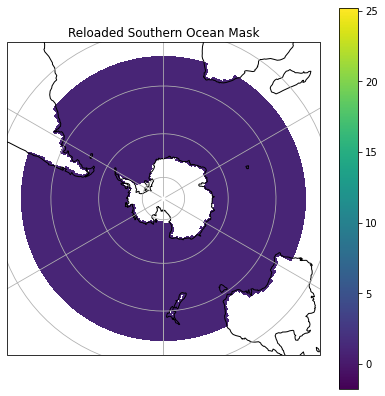

In [21]:
mapPlot(oceanMask, "Reloaded Southern Ocean Mask", 1)

<br>

#### Plotted Data

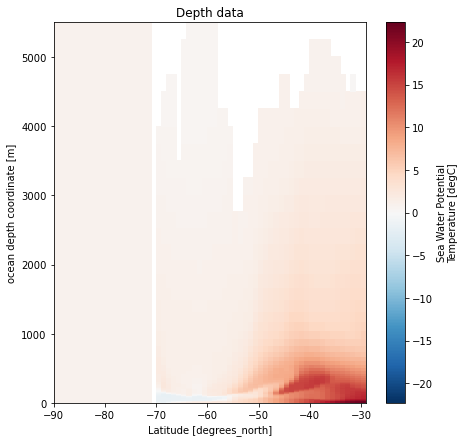

In [22]:
depthData = dataFiltLat.sel(time="2005-01", RunID=0, lon=0.5).copy()
tempProfilePlot(depthData, "Depth data", 1)

<br>